# Example MCI Computation

This notebooks runs MCI on the demo landscape used by Omniscape's documentation.    

## Setup

In [3]:
using Pkg
Pkg.activate("..")

using Test
using CairoMakie
using Circuitscape
using Omniscape
using SparseArrays
using Statistics
using Printf
using Random

using MerriamConnectivityIndicator

  Activating project at `~/Code/Workspaces/MerriamConnectivityIndicator`


## Download example data:

In [7]:
# Download example raster
url_base = "https://raw.githubusercontent.com/Circuitscape/datasets/main/"
mkpath("data")
download(string(url_base, "data/nlcd_2016_frederick_md.tif"), "example_landscape.tif")

"example_landscape.tif"

## Load Data and Map Landcover to Resistance

In [8]:
const NODATA = -9999
landcover, wkt, transform = Omniscape.read_raster("example_landscape.tif", Float64)
reclass_table = Dict([
    11 => 100.,       # Water
    21 => 500,       # Developed, open space
    22 => 1000,      # Developed, low intensity
    23 => NODATA,   # Developed, medium intensity
    24 => NODATA,   # Developed, high intensity
    31 => 100,       # Barren land
    41 => 1,         # Deciduous forest
    42 => 1,         # Evergreen forest
    43 => 1,         # Mixed forest
    52 => 20,        # Shrub/scrub
    71 => 30,        # Grassland/herbaceous
    81 => 200,       # Pasture/hay
    82 => 300,       # Cultivated crops
    90 => 20,        # Woody wetlands
    95 => 30,        # Emergent herbaceous wetlands
])

resistance = map(x -> reclass_table[x], landcover) 

694×725 Matrix{Float64}:
 300.0  300.0  300.0  300.0  300.0  300.0  …     1.0     1.0     1.0    1.0
 300.0  300.0  300.0  300.0  300.0  300.0        1.0     1.0     1.0    1.0
 300.0  300.0  300.0  300.0  300.0  300.0        1.0     1.0     1.0    1.0
 300.0  300.0  300.0  300.0  300.0  300.0        1.0     1.0     1.0    1.0
 300.0  300.0    1.0  300.0  300.0  300.0        1.0     1.0     1.0  200.0
   1.0    1.0    1.0    1.0    1.0    1.0  …     1.0     1.0   200.0  200.0
   1.0    1.0    1.0    1.0    1.0    1.0        1.0     1.0     1.0    1.0
   1.0    1.0    1.0    1.0    1.0    1.0        1.0     1.0     1.0  200.0
   1.0    1.0    1.0    1.0    1.0    1.0      200.0     1.0   200.0  200.0
   1.0    1.0    1.0    1.0    1.0    1.0      200.0     1.0   200.0  200.0
   ⋮                                  ⋮    ⋱                          
 300.0  300.0  300.0  300.0  300.0  300.0  …   300.0   300.0   300.0    1.0
 300.0  300.0  300.0  300.0  300.0  300.0      300.0   300.0   300.0

# Visualize Resistance

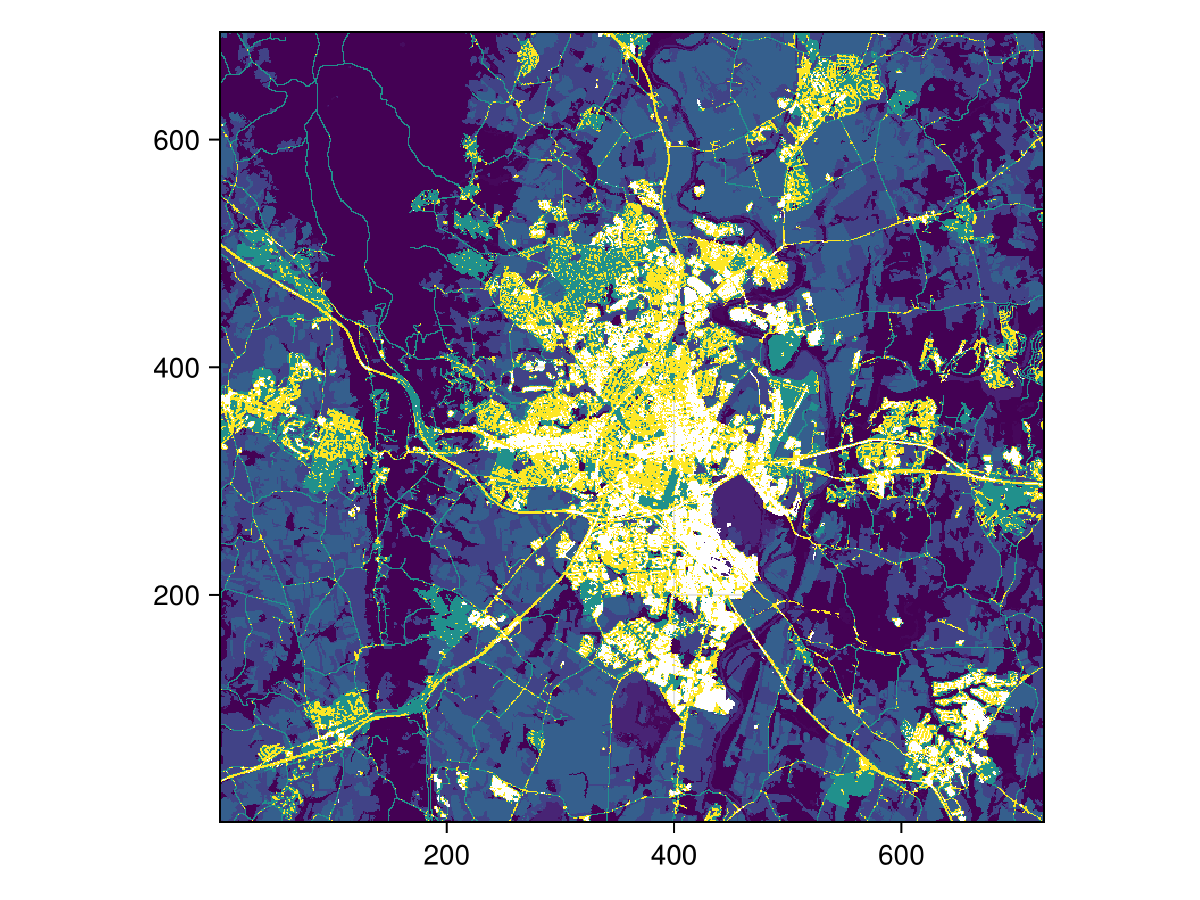

In [9]:
resist_plot = resistance
resist_plot[resistance .== NODATA] .= NaN
f = Figure()
ax = Axis(f[1,1], aspect=DataAspect())
heatmap!(ax, rotr90(resist_plot))
f

# Run MCI

In [11]:
config = MCIConfig(
        search_radius = 16,      # 20-pixel radius windows
        num_spokes = 8,          # 8 evenly-spaced source points
        injected_current = 1.0,  # Normalized current
        solver_type = "cholmod"   # AMG-preconditioned CG solver
)

mci_result = compute_mci(resistance, config) 

┌ Info: Computing MCI with 1 thread
└ @ MerriamConnectivityIndicator /Users/michael/Code/Workspaces/MerriamConnectivityIndicator/src/mci.jl:83
┌ Info: Processing 472395 windows (radius=16, spokes=8)
└ @ MerriamConnectivityIndicator /Users/michael/Code/Workspaces/MerriamConnectivityIndicator/src/mci.jl:96
Progress: 100%|█████████████████████████████████████████| Time: 0:05:15
┌ Info: MCI computation complete
└ @ MerriamConnectivityIndicator /Users/michael/Code/Workspaces/MerriamConnectivityIndicator/src/mci.jl:129


694×725 Matrix{Float64}:
 200.877     140.55      121.293     …   75.8376   69.2318   74.2933
 135.106      95.6135     81.5954        71.7115   68.9012   74.8643
 102.854      67.5407     59.2137        69.5452   67.4626   70.9996
  78.8294      4.19802     2.94858       71.3549   69.5827   73.2563
   2.11171     1.53286     1.13469       74.6748   73.3363   77.7926
   1.15356     0.96604     1.36107   …   79.6337   81.6818   86.1201
   0.992517    0.843143    0.875038      79.2937   79.4286   85.0142
   0.932834    0.778194    0.779406      81.11     81.426    87.8475
   0.903461    0.752776    0.717519      79.2473   85.3067   80.051
   0.884682    0.733758    0.689072      80.7899   73.6311  123.795
   ⋮                                 ⋱                      
 201.628     168.263     157.46      …   55.7334   31.0141   25.9141
 208.353     181.727     166.99          87.7377   36.7698   26.121
 209.703     178.507     167.47         102.425    97.8422  120.413
 201.49      180.731 

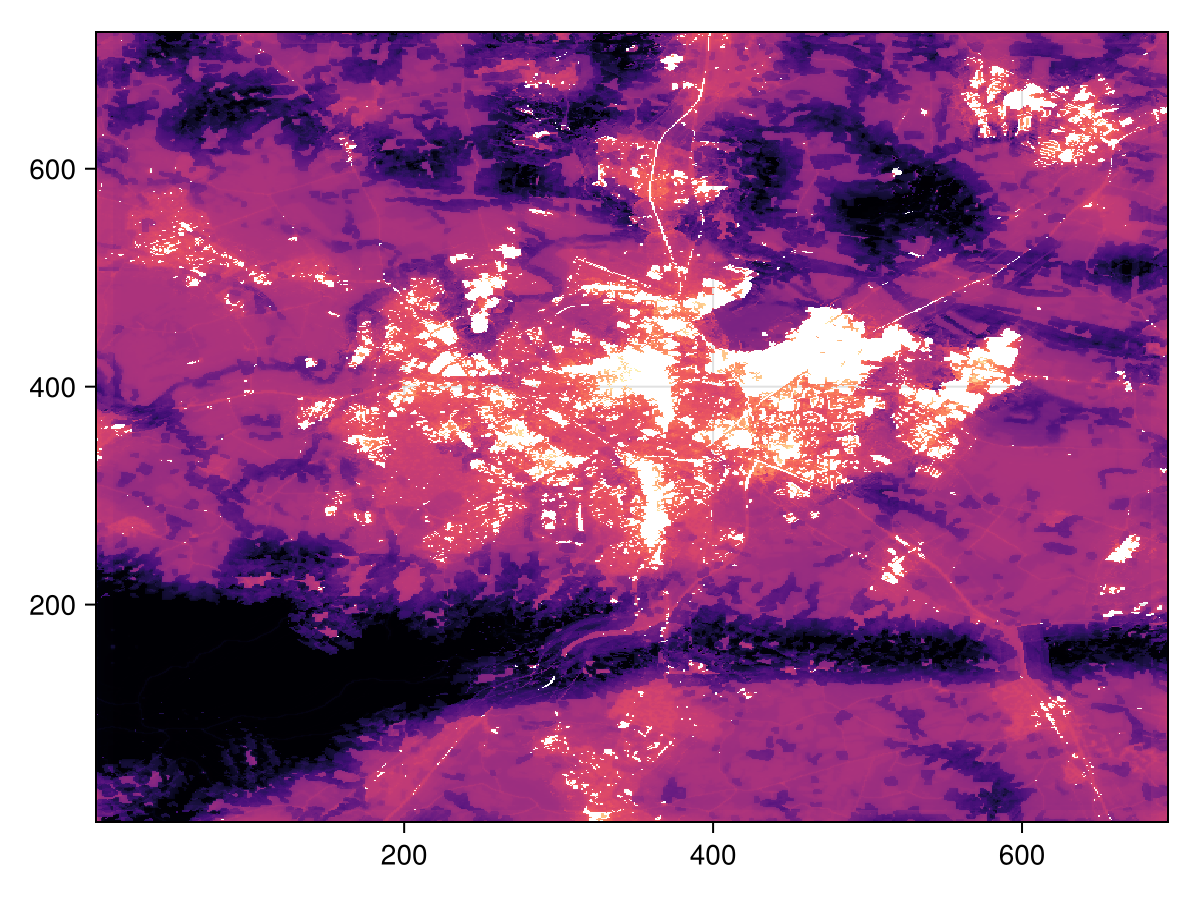

In [12]:
heatmap(log.(1 .+ mci_result), colormap=:magma) # Add one to avoid log(0) issues